# **Sequential Pattern Mining**

For the task related to Sequential Pattern Mining, the time series used is the original one based on the attribute CO(GT) with the noise remove.
analisi su tutto dataset

In [ ]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from scipy.stats.stats import pearsonr

In [ ]:
# script lettura dataset
df = pd.read_csv('TrainingTSgrande.csv', sep = ',', skipinitialspace=True, keep_default_na=True)

In [ ]:
df.head()

,DateTime,CO(GT),PT08.S1(CO),NOx(GT),NO2(GT),PT08.S4(NO2),T,Weekend
0,2004-10-23 22:00:00,2.60000,1297.0,283.000000,89.000000,1725.0,20.3,1
1,2004-09-03 02:00:00,2.15275,944.0,246.896735,113.091251,1407.0,24.0,0
2,2004-10-07 20:00:00,7.00000,1757.0,669.000000,117.000000,2280.0,23.2,0
3,2004-10-20 07:00:00,2.15275,1522.0,246.896735,113.091251,2043.0,18.8,0
4,2004-10-22 06:00:00,1.00000,982.0,185.000000,55.000000,1435.0,19.8,0


In [ ]:
df['DateTime']=pd.to_datetime(df.DateTime)

In [ ]:
df = df.set_index(['DateTime'])


In [ ]:
df.head()

,CO(GT),PT08.S1(CO),NOx(GT),NO2(GT),PT08.S4(NO2),T,Weekend
DateTime,,,,,,,
2004-10-23 22:00:00,2.60000,1297.0,283.000000,89.000000,1725.0,20.3,1
2004-09-03 02:00:00,2.15275,944.0,246.896735,113.091251,1407.0,24.0,0
2004-10-07 20:00:00,7.00000,1757.0,669.000000,117.000000,2280.0,23.2,0
2004-10-20 07:00:00,2.15275,1522.0,246.896735,113.091251,2043.0,18.8,0
2004-10-22 06:00:00,1.00000,982.0,185.000000,55.000000,1435.0,19.8,0


In [ ]:
df = df[['CO(GT)','Weekend']]
df.head()

,CO(GT),Weekend
DateTime,,
2004-10-23 22:00:00,2.60000,1
2004-09-03 02:00:00,2.15275,0
2004-10-07 20:00:00,7.00000,0
2004-10-20 07:00:00,2.15275,0
2004-10-22 06:00:00,1.00000,0


In [ ]:
df.shape

(1756, 2)

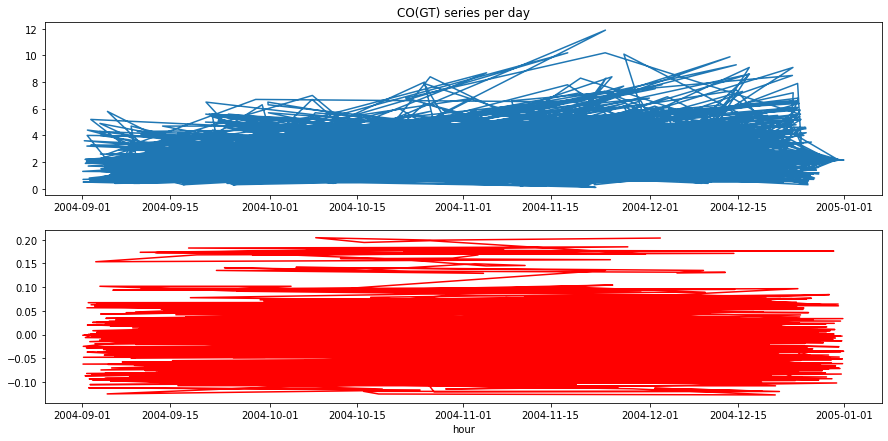

In [ ]:
w = 180
plt.figure(figsize=(15,7))
plt.subplot(212)
df_denoised = ((df['CO(GT)']-df['CO(GT)'].mean())/df['CO(GT)'].std()).rolling(window=w).mean()
plt.plot(df_denoised, c = 'red')
plt.xlabel('hour')

plt.subplot(211)
plt.plot(df['CO(GT)'])

plt.title('CO(GT) series per day')
plt.show()

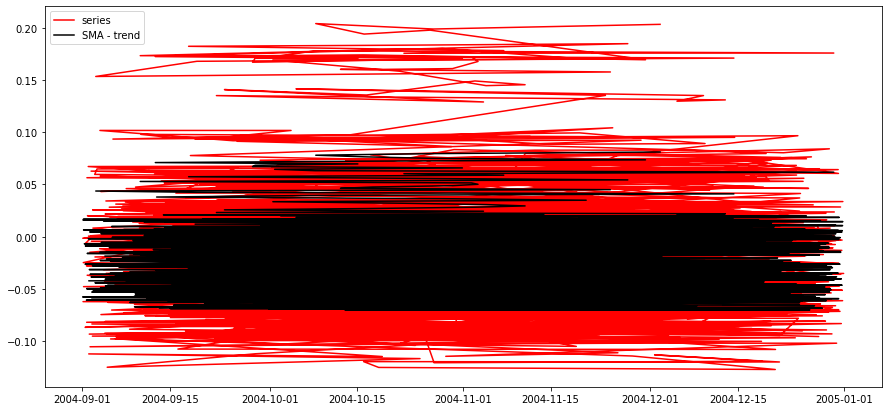

In [ ]:
ts = df_denoised.loc['2004-09-01':'2004-12-31']
sma = ts.rolling(window = 180).mean()      
plt.figure(figsize=(15,7))
plt.plot(ts, c ='red')
plt.plot(sma, c = 'black')
plt.legend(['series','SMA - trend'], loc = 'upper left')   
plt.show()

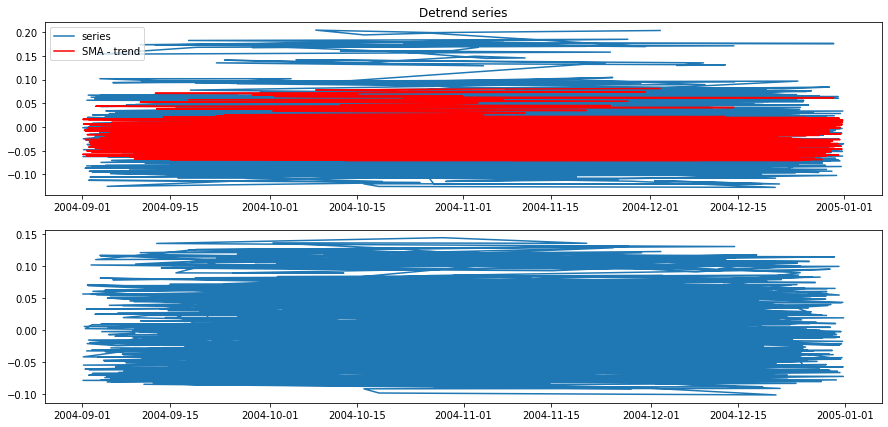

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(211)
ts = df_denoised.loc['2004-09-01':'2004-12-31']
sma = ts.rolling(window = 180).mean()      
plt.plot(ts)
plt.plot(sma, c = 'red')
plt.title('Detrend series')

plt.legend(['series','SMA - trend'], loc = 'upper left')   

plt.subplot(212)
ts_shift = ts - sma
plt.plot(ts_shift)
plt.show()

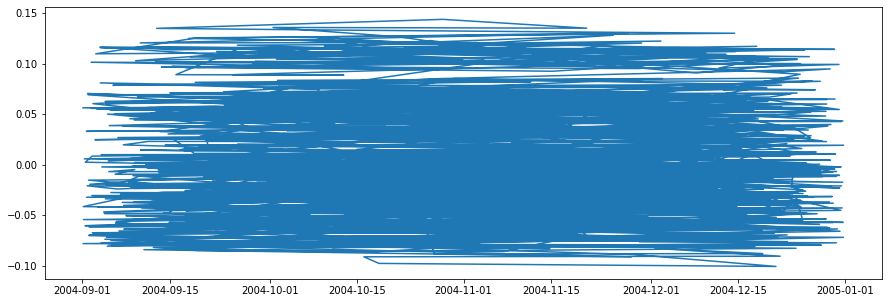

In [ ]:
ts = ts_shift['2004-09-01':'2004-12-31']
plt.figure(figsize =(15,5))
plt.plot(ts)

In [ ]:
len(ts)

1756

In [ ]:
ts = ts.values


In [ ]:
ts = ts[np.logical_not(np.isnan(ts))]

In [ ]:
len(ts)

1398

In [ ]:
ts.shape

(1398,)

In [ ]:
ts

array([-0.04487139, -0.04676382, -0.04795318, ...,  0.12622159,
        0.11947067,  0.12240193])

Array senza i null è di 386 elementi, perchè venga meglio ne riumuovo 2 a caso cosi di avere una base divisible per 4 per future analisi:

In [ ]:
ts = np.random.choice(ts, size=1398, replace=False)

In [ ]:
len(ts)

384

In [ ]:
# volevo dividerlo tipo come trovato in rete [240,30,1] ma aldilà dei valori non me lo permette prorpio, questa cosa blocca tutto
ts = ts.reshape(1,384,1)

ValueError: ignored

In [ ]:
ts.shape

(1, 384, 1)

In [ ]:
pip install tslearn

In [ ]:

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import SymbolicAggregateApproximation

## TS approximation


In [ ]:
# SAX transform
n_paa_segments = 50
n_sax_symbols = 80
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
ts_sax = sax.fit_transform(ts)
sax_ts_inv = sax.inverse_transform(ts_sax)

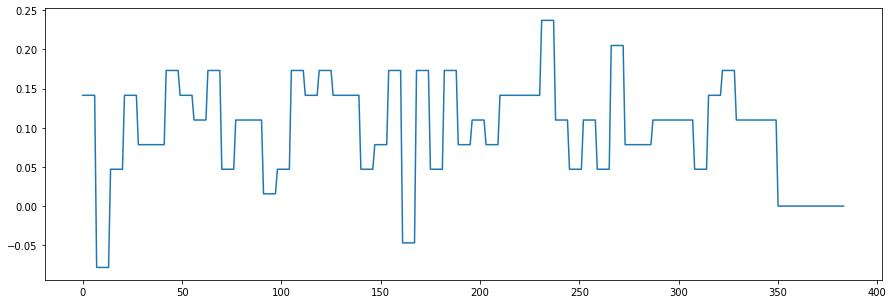

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(sax_ts_inv.ravel())
plt.show()

In [ ]:
map_symbols = {k: v for v, k in enumerate(np.unique(sax_ts_inv.ravel()))}
map_symbols

{-0.0784124127331122: 0,
 -0.04701659657781415: 1,
 0.0: 2,
 0.015667067624769982: 3,
 0.04701659657781429: 4,
 0.0784124127331122: 5,
 0.10988572976599126: 6,
 0.1414683013821586: 7,
 0.17319265100642342: 8,
 0.20509231571520872: 9,
 0.23720210932878769: 10}

In [ ]:
X_seq = list()
for x in sax_ts_inv:
    X_seq.append([map_symbols.get(v, -1) for v in x.ravel()])

In [ ]:
len(X_seq[0])


384

In [ ]:
len(X_seq)

1

PROVA A CREARE DUE ARRAY UNO CON 320 ELEMENTI E UNO CON 60 E POI METTERLI IN UN SOLO ARRAY (320,60,1)

## Creating transactional DataSet

### items

dalla sequenza della sax sono stati presi i valori di ogni singolo segmento (items).

In [ ]:
new_seq = []
for x in X_seq:
    new_seq.append(x[0])

In [ ]:
len(new_seq)

1

non va bene, perchè ho solo un items?

### elements

ogni 4 items sono stati raccolti in un element (ogni element rappresenta 2 ore)

In [ ]:
X_seq2H = []
i = 0
for i in range(0, 240, 4):
    X_seq2H.append((new_seq[i],new_seq[i+1],new_seq[i+2],new_seq[i+3]))

IndexError: ignored

In [ ]:
len(X_seq2H)


### Sequence

gni sequenza (corrispondente ad un differente giorno) è costituita da 12 elements

In [ ]:
X_seqdef = []
i = 0
for i in range(0, 60, 12):
    X_seqdef.append([X_seq2H[i],X_seq2H[i+1],X_seq2H[i+2],
                     X_seq2H[i+3],X_seq2H[i+4],X_seq2H[i+5],
                     X_seq2H[i+6],X_seq2H[i+7],X_seq2H[i+8],
                     X_seq2H[i+9],X_seq2H[i+10],X_seq2H[i+11]])

In [ ]:
len(X_seqdef)


## SPM

In [ ]:
pip install prefixspan


  Created wheel for prefixspan: filename=prefixspan-0.5.2-cp36-none-any.whl size=11219 sha256=3de602598a14d8e7c795b5240365b8b501bf2854cb5b7e4c3967ae06346d9a1c
  Stored in directory: /root/.cache/pip/wheels/31/73/e2/681c2d81b43389e5c8532de53dffc444304367c903026d4ba0
  Created wheel for extratools: filename=extratools-0.8.2.1-cp36-none-any.whl size=28868 sha256=ff784b8c7615ea905d002dd118a55f3a74e0d9eb48851b1ac6b67bd950a72d99
  Stored in directory: /root/.cache/pip/wheels/54/b8/e5/6ae8626c4b1543fecdcf15ead7e78bdf7ab7d42ee2076cb56b
Successfully built prefixspan extratools


In [ ]:
from prefixspan import PrefixSpan
